# Jigsaw unintended bias in toxicity classification 

### About the problem

   The Conversation AI team, a research initiative founded by Jigsaw and Google (both part of Alphabet), builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion.

Previously in 2018 the same competition was held with the task of classification comment text as toxic or not but the model built back then were focusing words like male, female ,white,black,gay_lesbian etc and marked those comments containing these words as more toxic when compared to comments without these words.

### Problem statement

Given comment text we need to predict whether the given comment is toxic or not .

### Loss 

Jigsaw built a custom AUC for this problem especially to remove unintended bias towards certain words.


#### Understanding the evalution metrics
https://medium.com/jash-data-sciences/measuring-unintended-bias-in-text-classification-a1d2e6630742

a. Subgroup AUC — This calculates AUC on only the examples from the subgroup. It represents model understanding and performance within the group itself. A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.

b. BNSP AUC — This calculates AUC on the positive examples from the background and the negative examples from the subgroup. A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not.

c. BPSN AUC — This calculates AUC on the negative examples from the background and the positive examples from the subgroup. A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not.

d. Final Metrics — We combine the overall AUC with the generalized mean of the Bias AUCs to calculate the final model score:

score=w0AUCoverall+∑a=1AwaMp(ms,a) where:

A = number of submetrics (3)

ms,a = bias metric for identity subgroup s using submetric a

wa = a weighting for the relative importance of each submetric; all four w values set to 0.25

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.model_selection import train_test_split
import string
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reading the data

In [2]:
# reading the data
df_train = pd.read_csv('train.csv')
df_test= pd.read_csv('test.csv')

print("shape of train data:", df_train.shape)
df_train.head()

shape of train data: (1804874, 45)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [3]:
df_train.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

There lots of attriutes along with text data where some of those attributes are meta data .

1.As mentioned in description of the competiton,identity columns are 'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish','muslim', 'black', 'white' and 'psychiatric_or_mental_illness'

2.Subtype attributes are:severe_toxicity,obscene,threat,insult,identity_attackandsexual_explicit



##### Creating target class

In [4]:
# assigning class labels based on kaggle's criteria , if target value is < 0.5 then it's non toxic else toxic
def label(target):                           
    return 0 if target < 0.5 else 1
        
df_train['class'] = df_train.apply(lambda x: label(x['target']), axis= 1)

I am dividing this case study into two parts 

1.Applying ML classification models and ensembling them at the end .

2.Applying DL models with various approaches

## PART1

 Iam only considering comment_text and dropping all other features.

# EDA 

#### Plotting target varible

Text(0, 0.5, 'comments count')

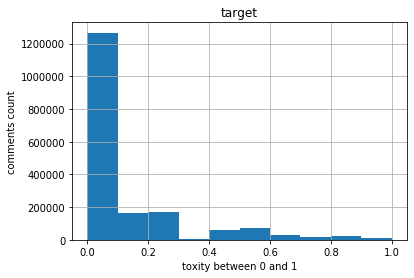

In [5]:
df_train.hist('target')
plt.xlabel("toxity between 0 and 1")
plt.ylabel("comments count")

Most of the comments are not toxic which means data should be hugely imbalanced.

In [6]:
n_unique_comments = df_train['comment_text'].nunique()
print('unique comments {} out of {}'.format(n_unique_comments,df_train.shape[0]))

unique comments 1780823 out of 1804874


#### Plotting derived target class

Text(0, 0.5, 'comments count')

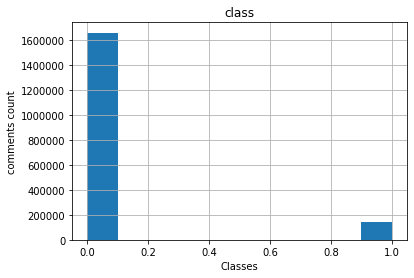

In [7]:
df_train.hist('class')
plt.xlabel("Classes")
plt.ylabel("comments count")


#### Distributions of size of comment text

C:\Users\santosh\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
C:\Users\santosh\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


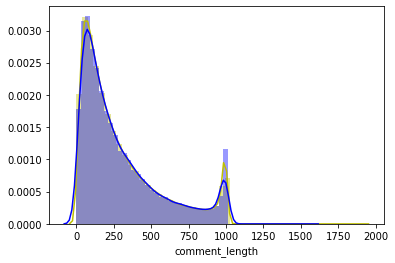

In [8]:
# no.of words in each comment text
df_train['comment_length'] = df_train['comment_text'].apply(lambda x : len(x)) 
df_test['comment_length'] = df_test['comment_text'].apply(lambda x : len(x))
sns.distplot(df_train['comment_length'],color="y")
sns.distplot(df_test['comment_length'],color="b")
plt.show()

Most comments are of lenght less then 1000 words and maximum comment lenght is approximately 1600 words

## Frequent  words appeared in toxic comments

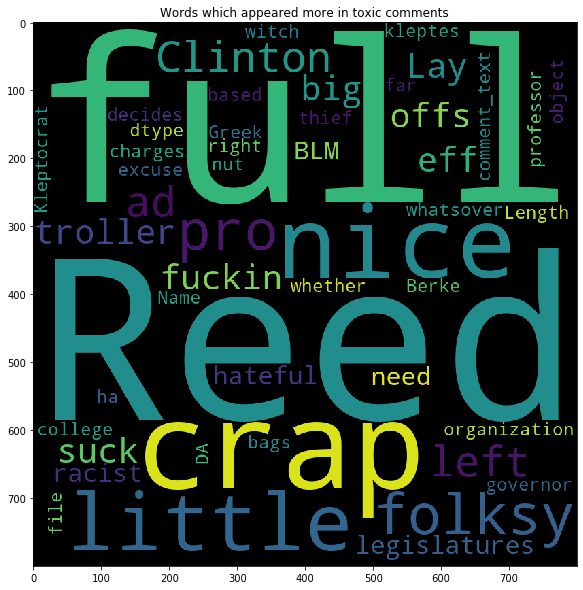

In [9]:
toxic_Words=(df_train.loc[df_train['target'] >= 0.5]['comment_text'].sample(100000))

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black').generate(str(toxic_Words)) 
  
                            
plt.figure(figsize = (10, 10), facecolor = None)
plt.title('Words which appeared more in toxic comments')
plt.imshow(wordcloud) 
plt.show()


1. We can see some words like idoit ,tax forbes etc are appeared  most of the times and note that even though forbes is not a toxic word but it appeared here because it might be due to following reasons:


(i)We just selected toxicity as greater than or equals to 0.5 that means the word containing forbes might be appeared close to 0.5 and may not be close to 1.

(ii)Another reason might be that the context of sentence made forbes as toxic . 

## Frequent  words appeared in non toxic comments

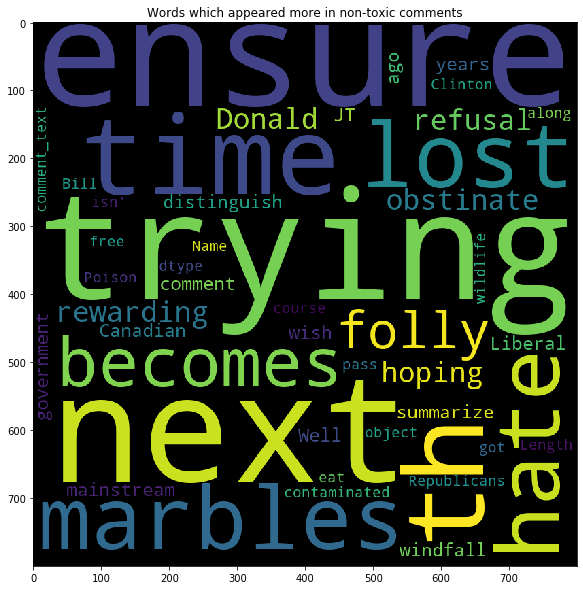

In [10]:
ntoxic_Words=(df_train.loc[df_train['target'] < 0.5]['comment_text'].sample(100000))

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black').generate(str(ntoxic_Words)) 
  
                            
plt.figure(figsize = (10, 10), facecolor = None)
plt.title('Words which appeared more in non-toxic comments')
plt.imshow(wordcloud) 
plt.show()


1. Words like testimony ,precincts ,canada ,canadians etc are appeared most of the times in non-toxic comments.

# Data Prepocessing

In [11]:
# Function to remove all contractions and auxillary words using 're' librabry
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

## Splitting data into train and cv

In [12]:
X_train, X_cv, y_train, y_cv = train_test_split(df_train, df_train['class'], test_size=0.33)
print('Data points in train {} and cv {}'. format(X_train.shape[0],X_cv.shape[0]))

Data points in train 1209265 and cv 595609


### NLP on comment

In [13]:
from tqdm import tqdm
preprocessed_text_train= []
for sentance in tqdm(X_train['comment_text'].values):
    sent1 = decontracted(sentance)# applying above defined function to remove auxillary words
    sent1 = sent1.replace('\\r', ' ')
    sent1 = sent1.replace('\\"', ' ')
    sent1 = sent1.replace('\\n', ' ')
    sent1 = re.sub('[^A-Za-z0-9]+', ' ', sent1)
    # https://gist.github.com/sebleier/554280
    stops = set(stopwords.words("english"))
    sent1 = ' '.join(e for e in sent1.split() if e not in stops)
    preprocessed_text_train.append(sent1.lower().strip())

100%|██████████████████████████████████████████████████████████████████████| 1209265/1209265 [07:05<00:00, 2839.21it/s]


In [14]:
preprocessed_text_cv= []

for sentance in tqdm(X_cv['comment_text'].values):
    sent1 = decontracted(sentance)
    sent1 = sent1.replace('\\r', ' ')
    sent1 = sent1.replace('\\"', ' ')
    sent1 = sent1.replace('\\n', ' ')
    sent1 = re.sub('[^A-Za-z0-9]+', ' ', sent1)
    # https://gist.github.com/sebleier/554280
    stops = set(stopwords.words("english"))
    sent1 = ' '.join(e for e in sent1.split() if e not in stops)
    preprocessed_text_cv.append(sent1.lower().strip())

100%|████████████████████████████████████████████████████████████████████████| 595609/595609 [03:25<00:00, 2903.68it/s]


In [15]:
preprocessed_text_test = []
for sentance in tqdm(df_test['comment_text'].values):
    sent1 = decontracted(sentance)
    sent1 = sent1.replace('\\r', ' ')
    sent1 = sent1.replace('\\"', ' ')
    sent1 = sent1.replace('\\n', ' ')
    sent1 = re.sub('[^A-Za-z0-9]+', ' ', sent1)
    # https://gist.github.com/sebleier/554280
    stops = set(stopwords.words("english"))
    sent1 = ' '.join(e for e in sent1.split() if e not in stops)
    preprocessed_text_test.append(sent1.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 97320/97320 [00:38<00:00, 2061.95it/s]


# Sentiment analysis on comment text

###### TEST

In [16]:
# POSITIVE,NEGATIVE ,NEURAL AND COMPOUND sentiment anlaysis on text 
test_neg = [] 
test_neu = []
test_pos = []
test_compound = []
#intializing  SentimentIntensityAnalyzer
sis = SentimentIntensityAnalyzer()

for words in preprocessed_text_test:
    pos1 = sis.polarity_scores(words)['pos']# these command line returns positive sentiment score if it finds any positive words
    neg1 = sis.polarity_scores(words)['neg']# these command line returns negative sentiment score if it finds any negative words
    neu1 = sis.polarity_scores(words)['neu']
    coump1 = sis.polarity_scores(words)['compound']
    #appending them in lists for further use 
    test_neg.append(neg1)
    test_pos.append(pos1)
    test_neu.append(neu1)
    test_compound.append(coump1)
# adding them into the data frame as features
df_test["senti_pos"]=test_pos
df_test["senti_neg"] =test_neg
df_test["senti_neu"] =test_neu
df_test["senti_com"] =test_compound

###### TRAIN

In [17]:
train_pos = []
train_neg = []
train_neu = []
train_compound = []

for words in preprocessed_text_train :
    pos1 = sis.polarity_scores(words)['pos']
    neg1 = sis.polarity_scores(words)['neg']
    neu1 = sis.polarity_scores(words)['neu']
    coump1 = sis.polarity_scores(words)['compound']
    train_neg.append(neg1)
    train_pos.append(pos1)
    train_neu.append(neu1)
    train_compound.append(coump1)
X_train["senti_pos"] =train_pos
X_train["senti_neg"] =train_neg
X_train["senti_neu"] =train_neu
X_train["senti_com"] =train_compound

###### CV

In [18]:

Cv_neg = []
Cv_neu = []
Cv_pos = []
Cv_compound = []

sis = SentimentIntensityAnalyzer()
for words in preprocessed_text_cv:
    pos1 = sis.polarity_scores(words)['pos']
    neg1 = sis.polarity_scores(words)['neg']
    neu1 = sis.polarity_scores(words)['neu']
    coump1 = sis.polarity_scores(words)['compound']
    Cv_neg.append(neg1)
    Cv_pos.append(pos1)
    Cv_neu.append(neu1)
    Cv_compound.append(coump1)
X_cv["senti_pos"] =Cv_pos
X_cv["senti_neg"] =Cv_neg
X_cv["senti_neu"] =Cv_neu
X_cv["senti_com"] =Cv_compound

#### Dropping other attritubes

In [21]:
# Dropping all other colunms
cols = [i for i in range (0 ,46)]
X_train.drop(X_train.columns[cols],axis=1,inplace=True)
X_cv.drop(X_cv.columns[cols],axis=1,inplace=True) 
df_test.drop(['id','comment_text'],axis=1,inplace=True)
print('Data for training:')
X_train

Data for training:


,comment_length,senti_pos,senti_neg,senti_neu,senti_com
738216,104,0.255,0.177,0.567,0.2732
1780513,595,0.113,0.092,0.795,-0.1396
478929,449,0.213,0.120,0.667,0.7184
1588434,86,0.257,0.151,0.592,0.3818
552789,81,0.000,0.219,0.781,-0.1027
...,...,...,...,...,...
247781,51,0.714,0.000,0.286,0.6124
1218418,599,0.107,0.076,0.817,0.2960
273096,458,0.104,0.227,0.669,-0.7184
1571981,157,0.000,0.301,0.699,-0.7220


## BOW on comment_text

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,2))
vectorizer.fit(preprocessed_text_train)

text_bow_train = vectorizer.transform(preprocessed_text_train)
text_bow_test = vectorizer.transform(preprocessed_text_test)
text_bow_cv = vectorizer.transform(preprocessed_text_cv)
print("Shape of matrix after one hot encoding ",text_bow_train.shape)
print("Shape of matrix after one hot encoding ",text_bow_test.shape)
print("Shape of matrix after one hot encoding ",text_bow_cv.shape)

Shape of matrix after one hot encoding  (1209265, 472764)
Shape of matrix after one hot encoding  (97320, 472764)
Shape of matrix after one hot encoding  (595609, 472764)


In [23]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
X_bow_train= hstack((text_bow_train,X_train)).tocsr()
X_bow_test= hstack((text_bow_test,df_test)).tocsr()
X_bow_cv= hstack((text_bow_cv,X_cv)).tocsr()

## TFIDF on comment_text

In [22]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,2))
vectorizer.fit(preprocessed_text_train)

text_tfidf_train = vectorizer.transform(preprocessed_text_train)
text_tfidf_test = vectorizer.transform(preprocessed_text_test)
text_tfidf_cv = vectorizer.transform(preprocessed_text_cv)
print("Shape of matrix after one hot encoding ",text_tfidf_train.shape)
print("Shape of matrix after one hot encoding ",text_tfidf_test.shape)
print("Shape of matrix after one hot encoding ",text_tfidf_cv.shape)

Shape of matrix after one hot encoding  (1209265, 472375)
Shape of matrix after one hot encoding  (97320, 472375)
Shape of matrix after one hot encoding  (595609, 472375)


In [24]:
X_tfidf_train= hstack((text_tfidf_train,X_train)).tocsr()
X_tfidf_test= hstack((text_tfidf_test,df_test)).tocsr()
X_tfidf_cv= hstack((text_tfidf_cv,X_cv)).tocsr()

In [25]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
   
    plt.figure(figsize=(10,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
 
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

# Applying ML models

## Logistic Regression 

### Logistic Regression with BOW on text


for alpha = 1e-05
Log Loss of CV : 0.19845498212067572

for alpha = 0.0001
Log Loss of CV : 0.20108116082839428

for alpha = 0.001
Log Loss of CV : 0.18784462988563402

for alpha = 0.01
Log Loss of CV : 0.2203499928478999

for alpha = 0.1
Log Loss of CV : 0.2477953386353881

for alpha = 1
Log Loss of CV : 0.26268748014874865

for alpha = 10
Log Loss of CV : 0.27541771167796253

for alpha = 100
Log Loss of CV : 0.2784080978070434


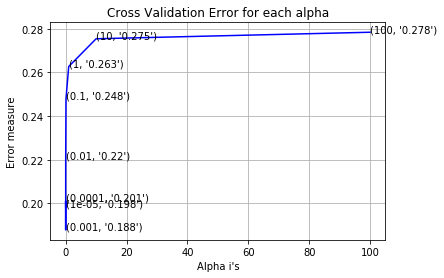


The best alpha is :  0.001


In [23]:
alpha = [10 ** x for x in range(-5, 3)]# tuning alpha 
cv_log_error_array = []
for i in alpha:
    print("\nfor alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(X_bow_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_bow_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_bow_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss of CV :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='b')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
print("\nThe best alpha is : ",alpha[best_alpha])

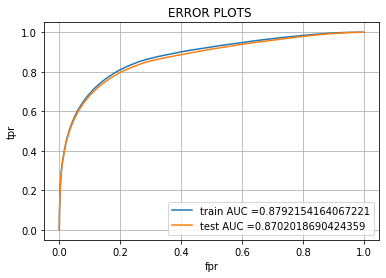

In [27]:
# Fitting for best alpha =0.001
lr1=SGDClassifier(alpha=0.001,class_weight='balanced',loss='log')
lr1.fit(X_bow_train, y_train)

y_train_pred = lr1.predict_proba(X_bow_train) [:,1]  
y_test_pred = lr1.predict_proba( X_bow_cv)[:,1]  

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)  

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS ")
plt.grid()
plt.show()

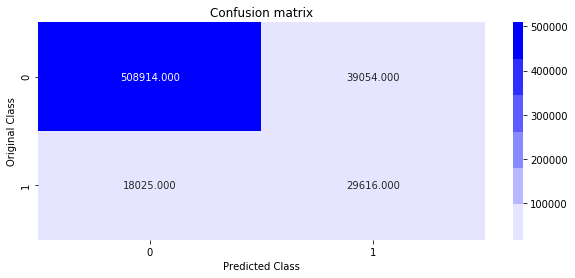

In [28]:
y_test_pred = lr1.predict( X_bow_cv)

plot_confusion_matrix(y_cv, y_test_pred)


1. We can see that both FP and FN values are high that means logistic regression with bow on text is not able to distinguish between the toxic and non toxic comment.
 



### Logistic Regression with tfidf on text


for alpha = 1e-05
Log Loss of CV : 0.2538091552098354

for alpha = 0.0001
Log Loss of CV : 0.24285203724356144

for alpha = 0.001
Log Loss of CV : 0.2631800497354351

for alpha = 0.01
Log Loss of CV : 0.2598935655636423

for alpha = 0.1
Log Loss of CV : 0.26126972410128

for alpha = 1
Log Loss of CV : 0.27147713696080483

for alpha = 10
Log Loss of CV : 0.27723103396671617

for alpha = 100
Log Loss of CV : 0.27843768045248074


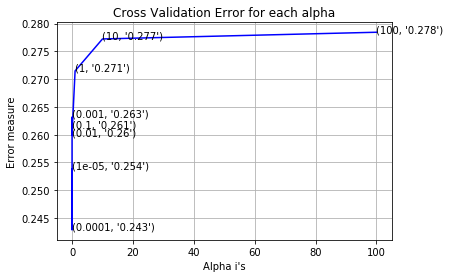


The best alpha is :  0.0001


In [43]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("\nfor alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(X_tfidf_train, y_train)
    # Using CalibratedClassifierCv to get probabilities close to exact probabilities
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tfidf_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_tfidf_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss of CV :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='b')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
print("\nThe best alpha is : ",alpha[best_alpha])

C:\Users\santosh\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\santosh\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\santosh\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\santosh\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\santosh\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_fig

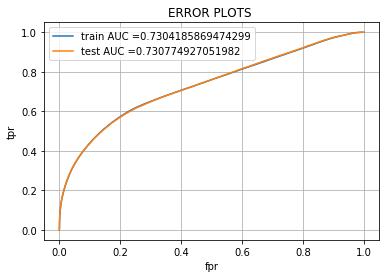

In [26]:
# fitting for best alpha
lr=SGDClassifier(alpha=0.0001,class_weight='balanced',loss='log')

lr.fit(X_tfidf_train, y_train)
y_train_pred = lr.predict_proba(X_tfidf_train) [:,1]  
y_test_pred = lr.predict_proba( X_tfidf_cv)[:,1]  

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)  

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS ")
plt.grid()
plt.show()

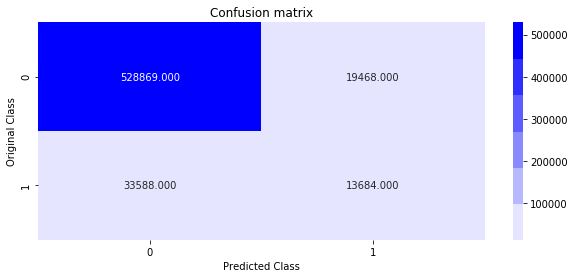

In [27]:
y_test_pred = lr.predict( X_tfidf_cv)

plot_confusion_matrix(y_cv, y_test_pred)


We can see that Logistic regression with tfidf on text has worse performance than LR with bow on text.

## SVM


##### SVM with BOW on text



for alpha = 1e-05
Log Loss of CV : 0.18018014081011732

for alpha = 0.0001
Log Loss of CV : 0.1826485327200237

for alpha = 0.001
Log Loss of CV : 0.20627384911782579

for alpha = 0.01
Log Loss of CV : 0.21884615521373316

for alpha = 0.1
Log Loss of CV : 0.2433297604715245

for alpha = 1
Log Loss of CV : 0.25877651836673593

for alpha = 10
Log Loss of CV : 0.27814037107980877

for alpha = 100
Log Loss of CV : 0.278464659652988


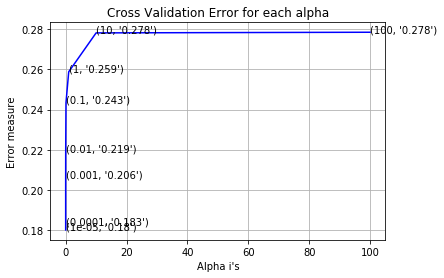


The best alpha is :  1e-05


In [57]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("\nfor alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42, n_jobs=-1)
    clf.fit(X_bow_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_bow_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_bow_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss of CV :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='b')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
print("\nThe best alpha is : ",alpha[best_alpha])

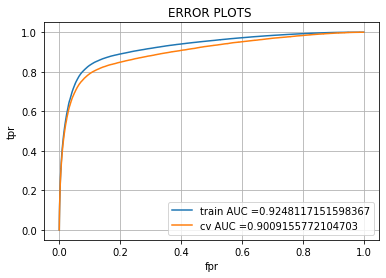

In [32]:
svm1=SGDClassifier(alpha=0.00001,class_weight='balanced',loss='hinge')

svm1.fit(X_bow_train, y_train)

y_train_pred = svm1.decision_function(X_bow_train) 
y_test_pred = svm1.decision_function( X_bow_cv) 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)  

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="cv AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS ")
plt.grid()
plt.show()

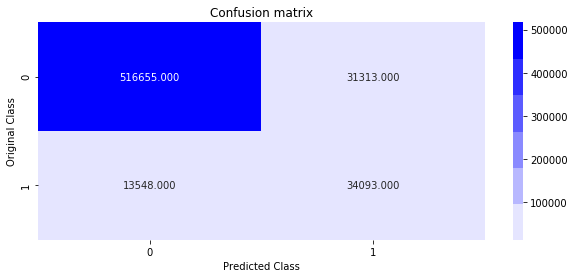

In [33]:
y_test_pred = svm1.predict( X_bow_cv)

plot_confusion_matrix(y_cv, y_test_pred)

Both logistic regression and SVM with BOW encoding performed significantly well .

#### SVM with TFIDF on text


for alpha = 1e-05
Log Loss of CV : 0.2586525018034489

for alpha = 0.0001
Log Loss of CV : 0.24814891485530965

for alpha = 0.001
Log Loss of CV : 0.24989308193063411

for alpha = 0.01
Log Loss of CV : 0.269752688686147

for alpha = 0.1
Log Loss of CV : 0.2605232370228004

for alpha = 1
Log Loss of CV : 0.2693938725447967

for alpha = 10
Log Loss of CV : 0.2782743181021718

for alpha = 100
Log Loss of CV : 0.2784738325424657


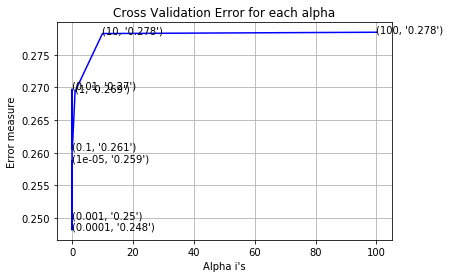


The best alpha is :  0.0001


In [64]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("\nfor alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42, n_jobs=-1)
    clf.fit(X_tfidf_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tfidf_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_tfidf_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss of CV :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='b')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
print("\nThe best alpha is : ",alpha[best_alpha])

C:\Users\santosh\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\santosh\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\santosh\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\santosh\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\santosh\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\santosh\Anaconda3

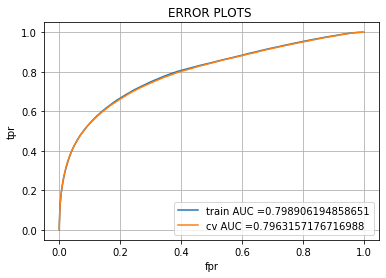

In [35]:
svm2=SGDClassifier(alpha=0.00001,class_weight='balanced',loss='hinge')

svm2.fit(X_tfidf_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = svm2.decision_function(X_tfidf_train) 
y_test_pred = svm2.decision_function( X_tfidf_cv) 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)  

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="cv AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS ")
plt.grid()

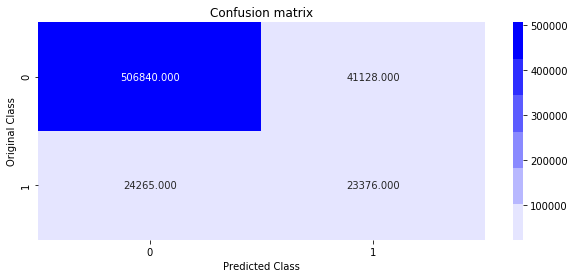

In [91]:
y_test_pred = svm2.predict( X_tfidf_cv)

plot_confusion_matrix(y_cv, y_test_pred)

## Stacking above all generated models

Just simply tried to stack each model created above

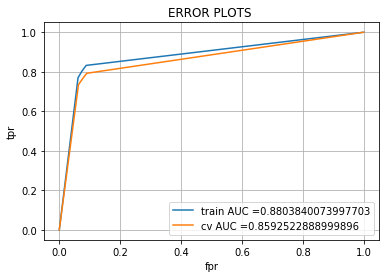

In [38]:
from mlxtend.classifier import StackingClassifier

sclf = StackingClassifier(classifiers=[lr, svm1, svm2], 
                          meta_classifier=lr1)


sclf.fit(X_bow_train, y_train)
y_train_pred = sclf.predict_proba(X_bow_train) [:,1]  
y_test_pred = sclf.predict_proba( X_bow_cv)[:,1]  

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)  

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="cv AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS ")
plt.grid()
plt.show()

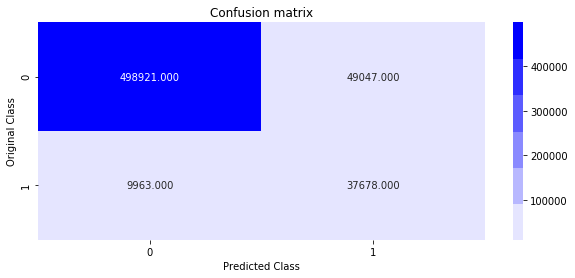

In [39]:
y_test_pred = sclf.predict( X_bow_cv)

plot_confusion_matrix(y_cv, y_test_pred)

# Conclusion

In [29]:
from prettytable import PrettyTable


conclusion= PrettyTable()
conclusion.field_names = ["Vectorizer", "Model", "standard cv AUC"]

conclusion.add_row(["BOW", "Logistic regression",0.89])
conclusion.add_row(["BOW", "SVM", 0.90])
conclusion.add_row(["TFIDF", "Logistic regression", 0.73])
conclusion.add_row(["TFIDF", "SVM", 0.79])
conclusion.add_row(["bow,tfidf", "Stacking models", 0.85])
print(conclusion)

+------------+---------------------+-----------------+
| Vectorizer |        Model        | standard cv AUC |
+------------+---------------------+-----------------+
|    BOW     | Logistic regression |       0.89      |
|    BOW     |         SVM         |       0.9       |
|   TFIDF    | Logistic regression |       0.73      |
|   TFIDF    |         SVM         |       0.79      |
| bow,tfidf  |   Stacking models   |       0.85      |
+------------+---------------------+-----------------+
